# CRIME DETECTION FROM SOCIAL MEDIA USING CONVOLUTIONAL NEURAL NETWORK

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
nltk.download('averaged_perceptron_tagger')

# Date
from dateutil.parser import parse
import datetime

# Model Imports
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sudar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# EDA 
### Step 1 - Data Sourcing 

In [2]:
### File - training.1600000.processed.noemoticon

tweets = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = 'ISO-8859-1', header=None)
tweets.columns = ["target", "ids", "date", "query", "user", "text"]

In [3]:
# Tweets dimension 
tweets.shape

(1600000, 6)

#### Checking Positive and Negative Tweets.

In [4]:
## Take Subset of Tweets due to performance issues. 
tweets_P = tweets[tweets.target == 4].head(1000)
tweets_NEU = tweets[tweets.target == 2].head(1000)
tweets_N = tweets[tweets.target == 0].head(1000)
tweets_P.head()

,target,ids,date,query,user,text
800000,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800001,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800002,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800004,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone


In [5]:
tweets = pd.concat([tweets_P,tweets_NEU,tweets_N])
tweets.shape

(2000, 6)

In [6]:
# What type of values are stored in the columns?
tweets.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 800000 to 999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  2000 non-null   int64 
 1   ids     2000 non-null   int64 
 2   date    2000 non-null   object
 3   query   2000 non-null   object
 4   user    2000 non-null   object
 5   text    2000 non-null   object
dtypes: int64(2), object(4)
memory usage: 109.4+ KB


In [7]:
# Checking the percentage of missing values
round(100*(tweets.isnull().sum()/len(tweets.index)), 2)

target    0.0
ids       0.0
date      0.0
query     0.0
user      0.0
text      0.0
dtype: float64

In [8]:
# To make sure that number of duplicate rows are zero, checking whether their is any duplicate applications.

print("Duplicate Row checks for tweets ->" + str(sum(tweets.duplicated(subset = "ids")) == 0))

Duplicate Row checks for tweets ->False


### Parameters

In [9]:
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Step 2 - Preprocessing

In [10]:
# TEXT CLENAING
### Remove Username 
### Remove Special Characters and Punctuations

def preprocess(text, stem=False):
     # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [11]:
### Remove Stop words 
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
tweets['mtext'] = tweets.text.apply(lambda x: preprocess(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sudar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Derive Attributes

In [12]:
### Identify URL's
def extractURL(text):
    urlstr = ""
    try:
        urlstr = re.search("(?P<url>https?://[^\s]+)", str(text)).group("url")
    except:
        urlstr = ""
    return urlstr

In [13]:
### Identify Entities's
def extractEntities(text):
    entities = ""
    try:
        entities = re.findall(r"@(\w+)", text)
    except:
        entities = ""
    return entities

In [14]:
### Extracting URL's from Tweet.
tweets['urls'] = tweets.text.apply(lambda x: extractURL(x))

In [15]:
### Identify valid URL and invalid URLs
def inValidURL(text):
    urlInValid = 0
    if text.startswith('http://'):
        urlInValid=1
    return urlInValid

In [16]:
tweets['inValidUrl'] = tweets.urls.apply(lambda x: inValidURL(x))

In [17]:
tweets['inValidUrl'].value_counts()

0    1922
1      78
Name: inValidUrl, dtype: int64

In [18]:
tweets['Parties'] = tweets.text.apply(lambda x: extractEntities(x))

In [19]:
### Identify Tweet Length 
tweets['TLen'] = tweets.mtext.str.len()

In [20]:
### Date Time conversion 
def parseDate(text):
    return parse(text)

def getDayOfWeek(text):
    weekday = pd.Timestamp(text).weekday()
    wday=""
    if weekday == 0:
        wday = "Monday"
    elif weekday == 1:
        wday = "Tuesday"
    elif weekday == 2:
        wday = "Wednesday"
    elif weekday == 3:
        wday = "Thursday"
    elif weekday == 4:
        wday = "Friday"
    elif weekday == 5:
        wday = "Saturday"
    elif weekday == 6:
        wday = "Sunday"
    else: 
        wday = ""
    return wday

def getTime(text):
    return pd.Timestamp(text).time()

def getMonth(text):
    return pd.Timestamp(text).month_name()


In [21]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [22]:
tweets.target = tweets.target.apply(lambda x: decode_sentiment(x))

In [23]:
tweets.head()

,target,ids,date,query,user,text,mtext,urls,inValidUrl,Parties,TLen
800000,POSITIVE,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!,love health4uandpets u guys r best,,0,[Health4UandPets],34
800001,POSITIVE,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...,im meeting one besties tonight cant wait girl ...,,0,[],50
800002,POSITIVE,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S...",thanks twitter add sunisa got meet hin show dc...,,0,[DaRealSunisaKim],62
800003,POSITIVE,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...,sick really cheap hurts much eat real food plu...,,0,[],65
800004,POSITIVE,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone,effect everyone,,0,[LovesBrooklyn2],15


In [24]:
tweets['date'] = tweets.date.apply(lambda x: parseDate(str(x)))

In [25]:
tweets['DayOfWeek'] = tweets.date.apply(lambda x: getDayOfWeek(x))
tweets['TweetTime'] = tweets.date.apply(lambda x: getTime(x))
tweets['MonthTweeted'] = tweets.date.apply(lambda x: getMonth(x))

In [26]:
tweets.head(5)

,target,ids,date,query,user,text,mtext,urls,inValidUrl,Parties,TLen,DayOfWeek,TweetTime,MonthTweeted
800000,POSITIVE,1467822272,2009-04-06 22:22:45,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!,love health4uandpets u guys r best,,0,[Health4UandPets],34,Monday,22:22:45,April
800001,POSITIVE,1467822273,2009-04-06 22:22:45,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...,im meeting one besties tonight cant wait girl ...,,0,[],50,Monday,22:22:45,April
800002,POSITIVE,1467822283,2009-04-06 22:22:46,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S...",thanks twitter add sunisa got meet hin show dc...,,0,[DaRealSunisaKim],62,Monday,22:22:46,April
800003,POSITIVE,1467822287,2009-04-06 22:22:46,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...,sick really cheap hurts much eat real food plu...,,0,[],65,Monday,22:22:46,April
800004,POSITIVE,1467822293,2009-04-06 22:22:46,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone,effect everyone,,0,[LovesBrooklyn2],15,Monday,22:22:46,April


In [27]:
### tweetsP is for data analysis

tweetsP = tweets
tweetsP['inValidUrl'] = tweetsP['inValidUrl'].map({1: 'InvalidUrl', 0 : 'ValidUrl'})


### POS Tagging

In [28]:
tweets['POS_TAGS'] = tweets.mtext.apply(lambda x: nltk.pos_tag(x))

In [29]:
tweets.head(1)

,target,ids,date,query,user,text,mtext,urls,inValidUrl,Parties,TLen,DayOfWeek,TweetTime,MonthTweeted,POS_TAGS
800000,POSITIVE,1467822272,2009-04-06 22:22:45,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!,love health4uandpets u guys r best,,ValidUrl,[Health4UandPets],34,Monday,22:22:45,April,"[(l, NN), (o, MD), (v, VB), (e, NN), ( , NNP),..."


### Data Analysis
### Univariate Analyis

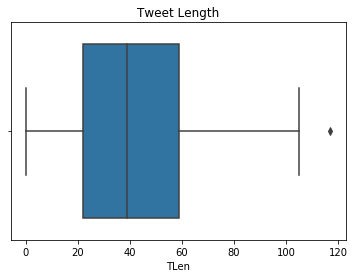

In [30]:
# boxplot
sns.boxplot(tweetsP['TLen'])
plt.title('Tweet Length')
plt.show()

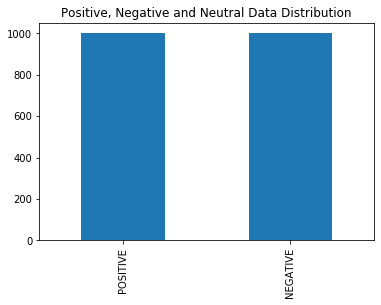

In [31]:
# Lets see the trend on Positive and Negative in Twitter dataset. 
tweetsP['target'].value_counts().plot(kind = 'bar',title = 'Positive, Negative and Neutral Data Distribution')

### Bivariate Analysis

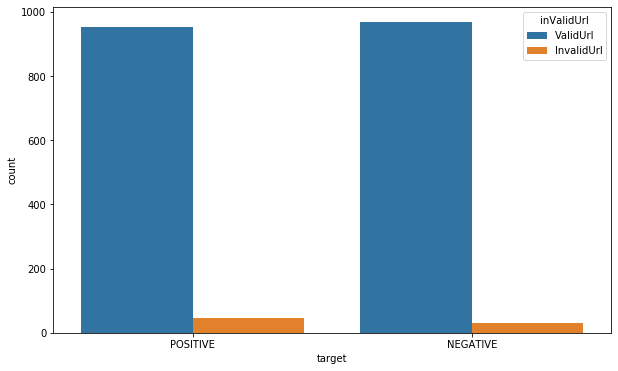

In [32]:
plt.figure(figsize=(10, 6))
sns.countplot(x="target", data=tweetsP,hue="inValidUrl")
plt.show()

In [33]:
# creating a time slot for various time period of day
def time_period(x):
    hours, minutes, Sec = str(x).split(":")
    'divide the time of the day into four categories'
    if int(hours) < 5:
        return "Early Morning"
    elif 5 <= int(hours) < 10:
        return "Morning"
    elif 10 <= int(hours) < 17:
        return "Day_Time"
    elif 17 <= int(hours) < 22:
        return "Evening_Rush"
    else:
        return "Late_Night"



In [34]:
# Tweet time 
tweetsP['time_slot'] = tweetsP.TweetTime.apply(lambda x: time_period(x))

In [35]:
# Let's create pie charts instead of a count plots
def pie_chart(dataframe, label):
    """
    creates a pie chart
    input: dataframe with a 'category' as index and a numerical column
    output: pie chart
    """
    labels = dataframe.index.values
    sizes = dataframe[label].values
        
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [36]:
pd.DataFrame(tweetsP.time_slot.value_counts())

,time_slot
Late_Night,2000


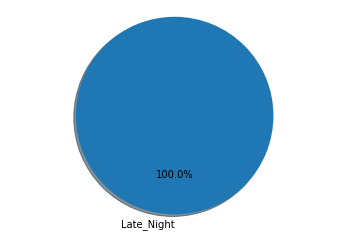

In [37]:
tweetsPT = pd.DataFrame(tweetsP.time_slot.value_counts())
pie_chart(tweetsPT, 'time_slot')

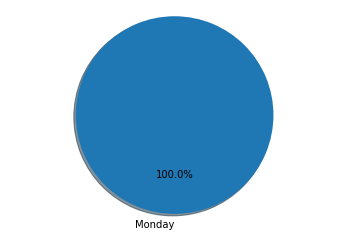

In [38]:
tweetsPT = pd.DataFrame(tweetsP.DayOfWeek.value_counts())
pie_chart(tweetsPT, 'DayOfWeek')

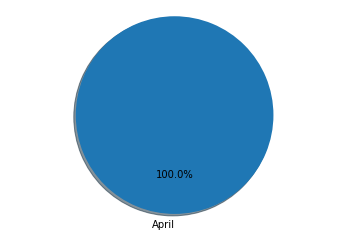

In [39]:
tweetsPT = pd.DataFrame(tweetsP.MonthTweeted.value_counts())
pie_chart(tweetsPT, 'MonthTweeted')

### Spliting dataset

In [40]:
## Splitting dataset into test and train 
df_train, df_test = train_test_split(tweets, test_size=0.30, random_state=42)

In [41]:
print("Tranining Dataset size -->" + str(df_train.shape))
print("Test Dataset size -->" + str(df_test.shape))

Tranining Dataset size -->(1400, 16)
Test Dataset size -->(600, 16)


### Word Embedding

In [42]:
# Word2vec
import gensim
from keras.preprocessing.text import Tokenizer
from pathlib import Path

Using TensorFlow backend.


In [43]:
### Word2Vec

w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [44]:
documents = [_text.split() for _text in df_train.mtext]
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 176


In [45]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(71898, 318944)

In [46]:
w2v_model.most_similar("love")

[('know', 0.9998518228530884),
 ('omg', 0.9998501539230347),
 ('haha', 0.9998480677604675),
 ('missed', 0.999846339225769),
 ('watch', 0.9998397827148438),
 ('well', 0.9998396635055542),
 ('wow', 0.9998396635055542),
 ('would', 0.9998387098312378),
 ('amp', 0.9998354911804199),
 ('people', 0.9998340606689453)]

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.mtext)
vocab_size = len(tokenizer.word_index) + 1
print("Total words --> ", vocab_size)

Total words -->  3703


In [48]:
matrix_wv = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    matrix_wv[i] = w2v_model.wv[word]
print(matrix_wv.shape)

(3703, 300)


In [49]:
### Glove 

root = Path('../')
input_path = root / 'input/'
ouput_path = root / 'output/'
source_path = root / 'source/'

glove_file = 'glove.twitter.27B.100d.txt'
emb_dict = {}
glove = open(glove_file, encoding="utf8")
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

In [50]:
NB_WORDS = len(emb_dict)+1  
GLOVE_DIM = 100

print('Total %s word vectors.' % len(emb_dict))

Total 1193514 word vectors.


In [51]:
matrix_gv = np.zeros((NB_WORDS, GLOVE_DIM))
for word, i in tokenizer.word_index.items():
    if i < NB_WORDS:
        vect = emb_dict.get(word)
        if vect is not None:
            matrix_gv[i] = vect
    else:
        break
print(matrix_gv.shape)

(1193515, 100)


### Creating Embedding layer

In [52]:
from keras.layers import Embedding

In [53]:
### Word To Vector Embedding Layer
wv_embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[matrix_wv], input_length=SEQUENCE_LENGTH, trainable=False)

In [54]:
### Glove Embedding Layer
gv_embedding_layer = Embedding(NB_WORDS, 100, weights=[matrix_gv], input_length=SEQUENCE_LENGTH, trainable=False)

### Word Padding

In [55]:
from keras.preprocessing.sequence import pad_sequences

In [56]:
x_train_pd = pad_sequences(tokenizer.texts_to_sequences(df_train.mtext), maxlen=SEQUENCE_LENGTH)
x_test_pd = pad_sequences(tokenizer.texts_to_sequences(df_test.mtext), maxlen=SEQUENCE_LENGTH)

### Model Building

##### Navie Bayes with TF-IDF

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]
}

In [58]:
x_train = df_train.mtext
y_train = df_train['target'].map({"NEGATIVE":1,"NEUTRAL":0,"POSITIVE":0})
x_test = df_test.mtext
y_test = df_test['target'].map({"NEGATIVE":1,"NEUTRAL":0,"POSITIVE":0 })

In [59]:
from sklearn.metrics import classification_report
clf = GridSearchCV(text_clf, tuned_parameters, cv=4, scoring='accuracy', n_jobs=-1)
clf.fit(x_train, y_train)

print(classification_report(y_test, clf.predict(x_test), digits=4))

              precision    recall  f1-score   support

           0     0.6745    0.6656    0.6700       302
           1     0.6656    0.6745    0.6700       298

    accuracy                         0.6700       600
   macro avg     0.6700    0.6700    0.6700       600
weighted avg     0.6701    0.6700    0.6700       600



##### SVM with TF-IDF

In [60]:
from sklearn.linear_model import SGDClassifier

In [61]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]
}

In [62]:
clf = GridSearchCV(text_clf, tuned_parameters, cv=4, scoring='accuracy', n_jobs=-1)
clf.fit(x_train, y_train)

print(classification_report(y_test, clf.predict(x_test), digits=4))

              precision    recall  f1-score   support

           0     0.7462    0.3212    0.4491       302
           1     0.5638    0.8893    0.6901       298

    accuracy                         0.6033       600
   macro avg     0.6550    0.6052    0.5696       600
weighted avg     0.6556    0.6033    0.5688       600



##### Logestic Regression with TF-IDF

In [63]:
from sklearn.linear_model import LogisticRegression
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [64]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression(n_jobs=1, C=1e5))])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2')
}

In [65]:
#clf = GridSearchCV(text_clf, tuned_parameters, cv=4, scoring='accuracy', n_jobs=-1)
#clf.fit(x_train, y_train)

#print(classification_report(y_test, clf.predict(x_test), digits=4))

## Neural Networks

#### LSTM with Word2Vec

In [66]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM, Conv2D, MaxPooling2D
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools

In [67]:
#encoder = LabelEncoder()
#encoder.fit(df_train.target.tolist())

#y_train = encoder.transform(df_train.target.tolist())
#y_test = encoder.transform(df_test.target.tolist())

#y_train = y_train.reshape(-1,1)
#y_test = y_test.reshape(-1,1)

#print("y_train",y_train.shape)
#print("y_test",y_test.shape)
y_train = df_train['target'].map({"NEGATIVE":1,"NEUTRAL":0,"POSITIVE":0})
y_test = df_test['target'].map({"NEGATIVE":1,"NEUTRAL":0,"POSITIVE":0 })

In [68]:
model = Sequential()
model.add(wv_embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          1110900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,271,401
Trainable params: 160,501
Non-trainable params: 1,110,900
_________________________________________________________________


In [69]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [70]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [71]:
history = model.fit(x_train_pd, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 1260 samples, validate on 140 samples
Epoch 1/8
1260/1260 [==============================] - 19s 15ms/step - loss: 0.6933 - accuracy: 0.5119 - val_loss: 0.6927 - val_accuracy: 0.5643
Epoch 2/8
1260/1260 [==============================] - 18s 15ms/step - loss: 0.6934 - accuracy: 0.4952 - val_loss: 0.6921 - val_accuracy: 0.5143
Epoch 3/8
1260/1260 [==============================] - 18s 15ms/step - loss: 0.6931 - accuracy: 0.5008 - val_loss: 0.6920 - val_accuracy: 0.5143
Epoch 4/8
1260/1260 [==============================] - 18s 14ms/step - loss: 0.6949 - accuracy: 0.4992 - val_loss: 0.6920 - val_accuracy: 0.5143
Epoch 5/8
1260/1260 [==============================] - 17s 13ms/step - loss: 0.6946 - accuracy: 0.5032 - val_loss: 0.6922 - val_accuracy: 0.5071
Epoch 6/8
1260/1260 [==============================] - 18s 14ms/step - loss: 0.6936 - accuracy: 0.5032 - val_loss: 0.6928 - val_accuracy: 0.5143
Epoch 7/8
1260/1260 [==============

In [72]:
score = model.evaluate(x_test_pd, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

600/600 [==============================] - 2s 4ms/step

ACCURACY: 0.49166667461395264
LOSS: 0.6940184235572815


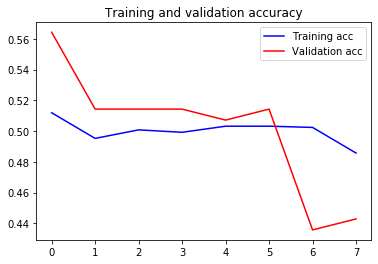

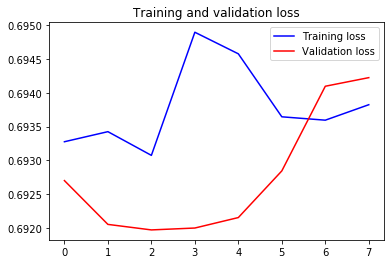

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [74]:
# Predict

# SENTIMENT
POSITIVE = 0
NEGATIVE = 1
NEUTRAL = 0
SENTIMENT_THRESHOLDS = (0.4, 0.7)

def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label =  POSITIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = NEGATIVE

        return label
    else:
        return NEGATIVE if score > 0.5 else POSITIVE

In [75]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [76]:
y_pred_1d = []
y_test_1d = list(y_test)
scores = model.predict(x_test_pd, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

600/600 [==============================] - 3s 5ms/step


In [77]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

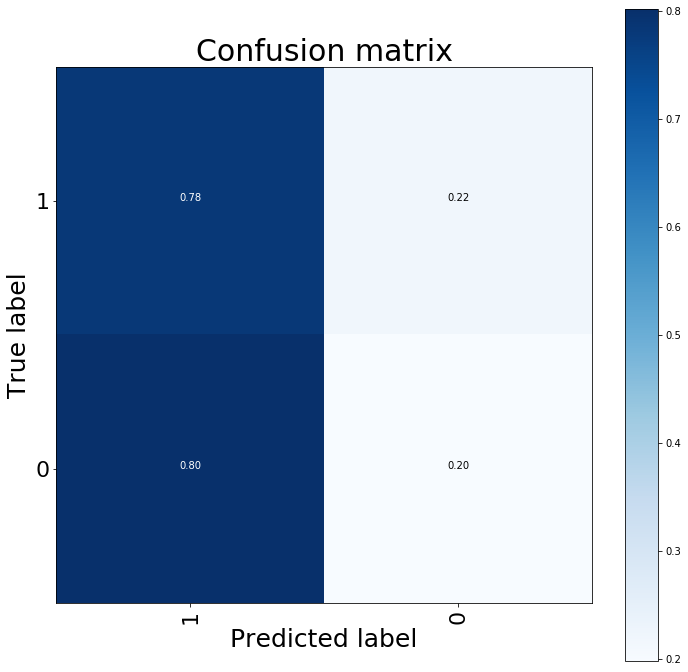

In [78]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=y_test.unique(), title="Confusion matrix")
plt.show()

In [79]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

           0       0.50      0.78      0.61       302
           1       0.47      0.20      0.28       298

    accuracy                           0.49       600
   macro avg       0.48      0.49      0.44       600
weighted avg       0.48      0.49      0.44       600



In [80]:
accuracy_score(y_test_1d, y_pred_1d)

0.49166666666666664

### 1D Convolution Layer

In [81]:
model = Sequential()
model.add(wv_embedding_layer)
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          1110900   
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 298, 64)           57664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 298, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 149, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [82]:
history = model.fit(x_train_pd, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1260 samples, validate on 140 samples
Epoch 1/8
1260/1260 [==============================] - 9s 7ms/step - loss: 0.6937 - accuracy: 0.4881 - val_loss: 0.6930 - val_accuracy: 0.4929
Epoch 2/8
1260/1260 [==============================] - 8s 7ms/step - loss: 0.6928 - accuracy: 0.5405 - val_loss: 0.6927 - val_accuracy: 0.4929
Epoch 3/8
1260/1260 [==============================] - 8s 6ms/step - loss: 0.6929 - accuracy: 0.4944 - val_loss: 0.6923 - val_accuracy: 0.5286
Epoch 4/8
1260/1260 [==============================] - 8s 6ms/step - loss: 0.6922 - accuracy: 0.5286 - val_loss: 0.6919 - val_accuracy: 0.5214
Epoch 5/8
1260/1260 [==============================] - 8s 6ms/step - loss: 0.6921 - accuracy: 0.5095 - val_loss: 0.6915 - val_accuracy: 0.5071
Epoch 6/8
1260/1260 [==============================] - 8s 6ms/step - loss: 0.6922 - accuracy: 0.5032 - val_loss: 0.6911 - val_accuracy: 0.4929
Epoch 7/8
1260/1260 [==============================] - 8s 6ms/step - loss: 0.6919 - accuracy: 0

In [83]:
y_pred_1d = []
y_test_1d = list(y_test)
scores = model.predict(x_test_pd, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

600/600 [==============================] - 1s 2ms/step


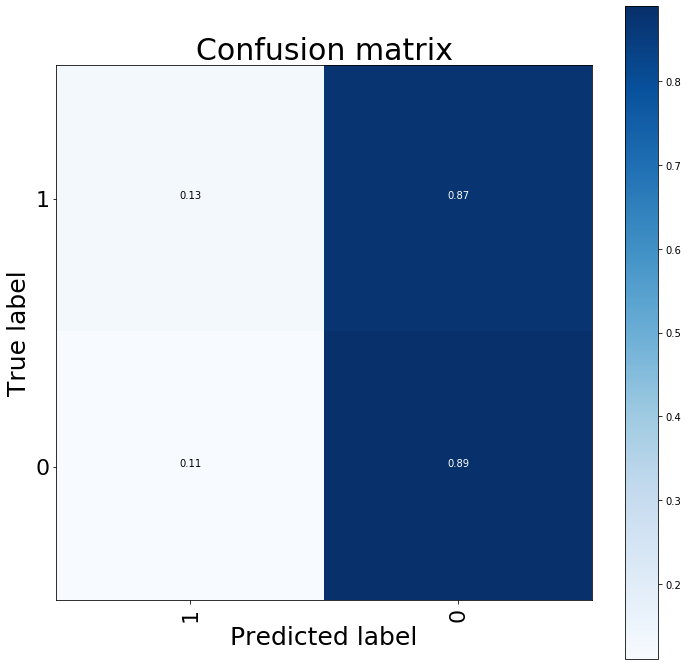

In [84]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=y_test.unique(), title="Confusion matrix")
plt.show()

In [85]:
accuracy_score(y_test_1d, y_pred_1d)

0.505

### 1D Convolution Layer and LSTM

In [86]:
model = Sequential()
model.add(wv_embedding_layer)
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          1110900   
_________________________________________________________________
dropout_4 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 298, 64)           57664     
_________________________________________________________________
dropout_5 (Dropout)          (None, 298, 64)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 99, 64)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 99, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)              

In [87]:
history = model.fit(x_train_pd, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1260 samples, validate on 140 samples
Epoch 1/8
1260/1260 [==============================] - 13s 10ms/step - loss: 0.6930 - accuracy: 0.4968 - val_loss: 0.6929 - val_accuracy: 0.5143
Epoch 2/8
1260/1260 [==============================] - 11s 9ms/step - loss: 0.6931 - accuracy: 0.5071 - val_loss: 0.6935 - val_accuracy: 0.4714
Epoch 3/8
1260/1260 [==============================] - 11s 9ms/step - loss: 0.6940 - accuracy: 0.4897 - val_loss: 0.6942 - val_accuracy: 0.4857
Epoch 4/8
1260/1260 [==============================] - 12s 9ms/step - loss: 0.6946 - accuracy: 0.5024 - val_loss: 0.6944 - val_accuracy: 0.4857
Epoch 5/8
1260/1260 [==============================] - 11s 9ms/step - loss: 0.6938 - accuracy: 0.4881 - val_loss: 0.6943 - val_accuracy: 0.4857
Epoch 6/8
1260/1260 [==============================] - 11s 9ms/step - loss: 0.6937 - accuracy: 0.5111 - val_loss: 0.6938 - val_accuracy: 0.4643
Epoch 7/8
1260/1260 [==============================] - 12s 9ms/step - loss: 0.6928 - acc

In [88]:
y_pred_1d = []
y_test_1d = list(y_test)
scores = model.predict(x_test_pd, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

600/600 [==============================] - 2s 3ms/step


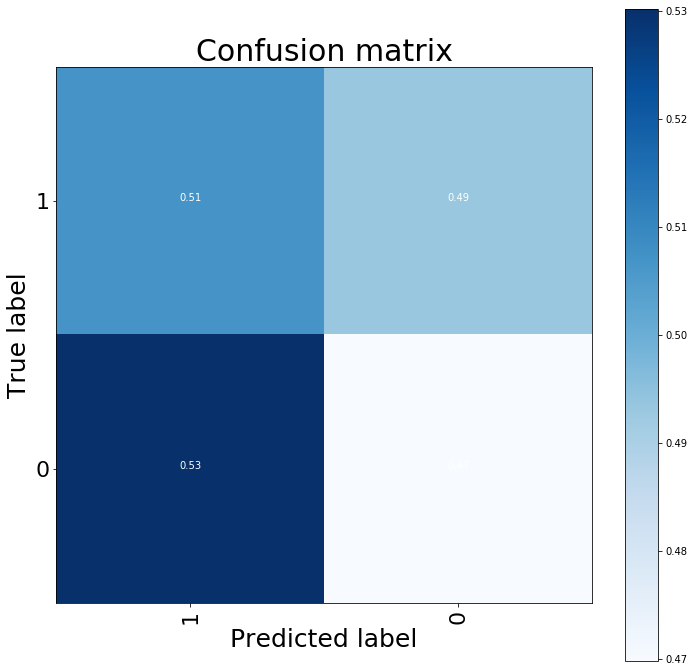

In [89]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=y_test.unique(), title="Confusion matrix")
plt.show()

In [90]:
accuracy_score(y_test_1d, y_pred_1d)

0.48833333333333334

### LSTM With Glove

In [91]:
model = Sequential()
model.add(gv_embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          119351500 
_________________________________________________________________
dropout_7 (Dropout)          (None, 300, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 119,432,001
Trainable params: 80,501
Non-trainable params: 119,351,500
_________________________________________________________________


In [92]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

history = model.fit(x_train_pd, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1260 samples, validate on 140 samples
Epoch 1/8
1260/1260 [==============================] - 13s 10ms/step - loss: 0.6999 - accuracy: 0.5040 - val_loss: 0.6800 - val_accuracy: 0.5857
Epoch 2/8
1260/1260 [==============================] - 12s 9ms/step - loss: 0.6911 - accuracy: 0.5397 - val_loss: 0.6670 - val_accuracy: 0.6214
Epoch 3/8
1260/1260 [==============================] - 12s 9ms/step - loss: 0.6784 - accuracy: 0.5762 - val_loss: 0.6562 - val_accuracy: 0.6714
Epoch 4/8
1260/1260 [==============================] - 12s 9ms/step - loss: 0.6687 - accuracy: 0.6040 - val_loss: 0.6484 - val_accuracy: 0.6500
Epoch 5/8
1260/1260 [==============================] - 12s 10ms/step - loss: 0.6611 - accuracy: 0.6024 - val_loss: 0.6408 - val_accuracy: 0.6643
Epoch 6/8
1260/1260 [==============================] - 12s 9ms/step - loss: 0.6554 - accuracy: 0.6357 - val_loss: 0.6314 - val_accuracy: 0.6857
Epoch 7/8
1260/1260 [==============================] - 12s 9ms/step - loss: 0.6448 - ac

In [93]:
y_pred_1d = []
y_test_1d = list(y_test)
scores = model.predict(x_test_pd, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

600/600 [==============================] - 2s 3ms/step


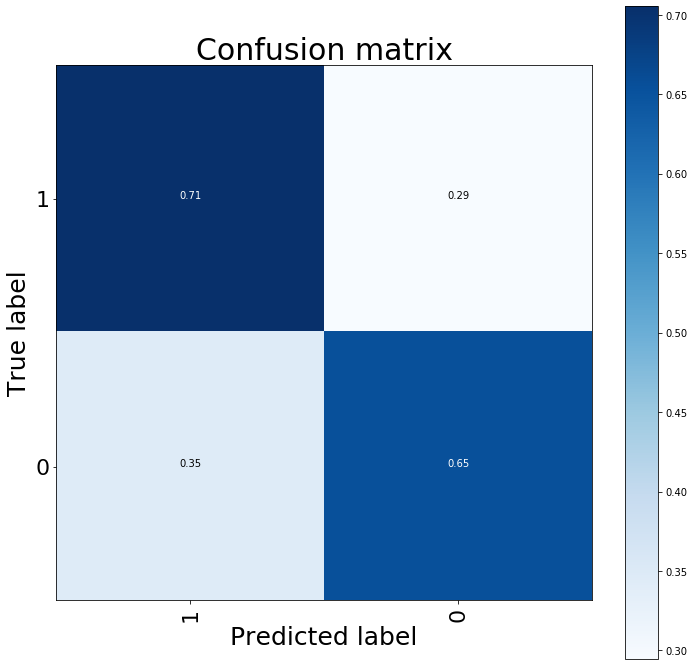

In [94]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=y_test.unique(), title="Confusion matrix")
plt.show()

In [95]:
accuracy_score(y_test_1d, y_pred_1d)

0.68

### CNN with Glove

In [96]:
model = Sequential()
model.add(gv_embedding_layer)
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          119351500 
_________________________________________________________________
dropout_8 (Dropout)          (None, 300, 100)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 298, 64)           19264     
_________________________________________________________________
dropout_9 (Dropout)          (None, 298, 64)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 149, 64)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9536)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [97]:
history = model.fit(x_train_pd, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1260 samples, validate on 140 samples
Epoch 1/8
1260/1260 [==============================] - 4s 3ms/step - loss: 0.6988 - accuracy: 0.4976 - val_loss: 0.6877 - val_accuracy: 0.6000
Epoch 2/8
1260/1260 [==============================] - 3s 3ms/step - loss: 0.6943 - accuracy: 0.5016 - val_loss: 0.6865 - val_accuracy: 0.6214
Epoch 3/8
1260/1260 [==============================] - 3s 3ms/step - loss: 0.6932 - accuracy: 0.5357 - val_loss: 0.6844 - val_accuracy: 0.5857
Epoch 4/8
1260/1260 [==============================] - 3s 3ms/step - loss: 0.6907 - accuracy: 0.5333 - val_loss: 0.6814 - val_accuracy: 0.5714
Epoch 5/8
1260/1260 [==============================] - 3s 3ms/step - loss: 0.6802 - accuracy: 0.5667 - val_loss: 0.6782 - val_accuracy: 0.6286
Epoch 6/8
1260/1260 [==============================] - 3s 3ms/step - loss: 0.6808 - accuracy: 0.5714 - val_loss: 0.6749 - val_accuracy: 0.6571
Epoch 7/8
1260/1260 [==============================] - 3s 3ms/step - loss: 0.6775 - accuracy: 0

In [98]:
y_pred_1d = []
y_test_1d = list(y_test)
scores = model.predict(x_test_pd, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]


600/600 [==============================] - 1s 1ms/step


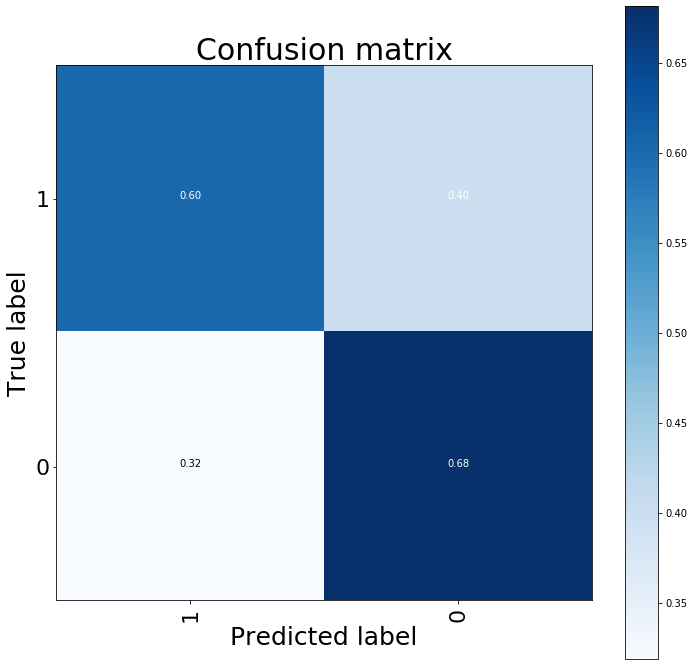

In [99]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=y_test.unique(), title="Confusion matrix")
plt.show()

### LSTM with CNN and Glove

In [100]:
model = Sequential()
model.add(gv_embedding_layer)
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          119351500 
_________________________________________________________________
dropout_10 (Dropout)         (None, 300, 100)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 298, 64)           19264     
_________________________________________________________________
dropout_11 (Dropout)         (None, 298, 64)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 99, 64)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 99, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)              

In [101]:
history = model.fit(x_train_pd, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1260 samples, validate on 140 samples
Epoch 1/8
1260/1260 [==============================] - 9s 7ms/step - loss: 0.7185 - accuracy: 0.4905 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 2/8
1260/1260 [==============================] - 7s 6ms/step - loss: 0.7034 - accuracy: 0.5024 - val_loss: 0.7056 - val_accuracy: 0.5000
Epoch 3/8
1260/1260 [==============================] - 7s 6ms/step - loss: 0.7036 - accuracy: 0.5040 - val_loss: 0.7045 - val_accuracy: 0.4929
Epoch 4/8
1260/1260 [==============================] - 7s 6ms/step - loss: 0.7023 - accuracy: 0.5032 - val_loss: 0.6961 - val_accuracy: 0.5143
Epoch 5/8
1260/1260 [==============================] - 7s 6ms/step - loss: 0.7013 - accuracy: 0.4984 - val_loss: 0.6894 - val_accuracy: 0.5714
Epoch 6/8
1260/1260 [==============================] - 7s 6ms/step - loss: 0.6954 - accuracy: 0.5087 - val_loss: 0.6856 - val_accuracy: 0.5857
Epoch 7/8
1260/1260 [==============================] - 7s 6ms/step - loss: 0.6982 - accuracy: 0

600/600 [==============================] - 1s 2ms/step


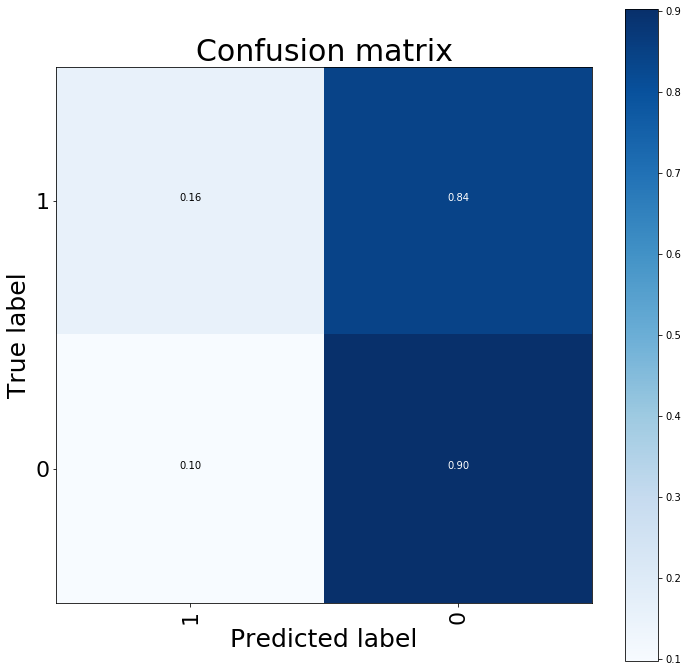

0.5283333333333333

In [102]:
y_pred_1d = []
y_test_1d = list(y_test)
scores = model.predict(x_test_pd, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]


cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=y_test.unique(), title="Confusion matrix")
plt.show()

accuracy_score(y_test_1d, y_pred_1d)

### LSTM and CNN (3 LAYERS)  

In [103]:
model = Sequential()
model.add(gv_embedding_layer)
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          119351500 
_________________________________________________________________
dropout_13 (Dropout)         (None, 300, 100)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 298, 64)           19264     
_________________________________________________________________
dropout_14 (Dropout)         (None, 298, 64)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 296, 64)           12352     
_________________________________________________________________
dropout_15 (Dropout)         (None, 296, 64)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 294, 64)          

In [104]:
history = model.fit(x_train_pd, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1260 samples, validate on 140 samples
Epoch 1/8
1260/1260 [==============================] - 13s 10ms/step - loss: 0.7002 - accuracy: 0.5024 - val_loss: 0.6955 - val_accuracy: 0.4857
Epoch 2/8
1260/1260 [==============================] - 11s 9ms/step - loss: 0.7079 - accuracy: 0.5016 - val_loss: 0.6964 - val_accuracy: 0.4857
Epoch 3/8
1260/1260 [==============================] - 11s 9ms/step - loss: 0.7061 - accuracy: 0.4762 - val_loss: 0.6941 - val_accuracy: 0.4714
Epoch 4/8
1260/1260 [==============================] - 11s 9ms/step - loss: 0.6947 - accuracy: 0.5135 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 5/8
1260/1260 [==============================] - 11s 9ms/step - loss: 0.6979 - accuracy: 0.4913 - val_loss: 0.6928 - val_accuracy: 0.4929
Epoch 6/8
1260/1260 [==============================] - 11s 9ms/step - loss: 0.6972 - accuracy: 0.4921 - val_loss: 0.6927 - val_accuracy: 0.5214
Epoch 7/8
1260/1260 [==============================] - 11s 9ms/step - loss: 0.6945 - acc

600/600 [==============================] - 2s 3ms/step


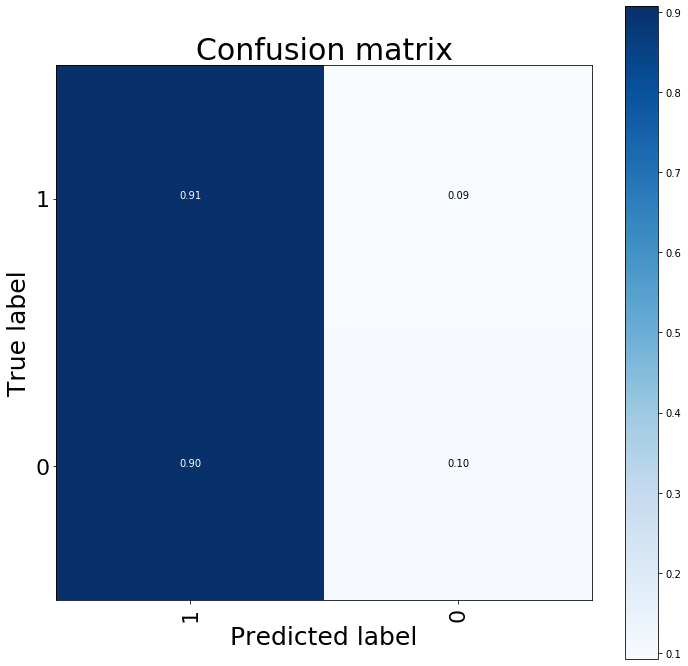

0.505

In [105]:
y_pred_1d = []
y_test_1d = list(y_test)
scores = model.predict(x_test_pd, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]


cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=y_test.unique(), title="Confusion matrix")
plt.show()

accuracy_score(y_test_1d, y_pred_1d)

In [106]:
### Final Analysis

In [107]:
tweets.head()

,target,ids,date,query,user,text,mtext,urls,inValidUrl,Parties,TLen,DayOfWeek,TweetTime,MonthTweeted,POS_TAGS,time_slot
800000,POSITIVE,1467822272,2009-04-06 22:22:45,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!,love health4uandpets u guys r best,,ValidUrl,[Health4UandPets],34,Monday,22:22:45,April,"[(l, NN), (o, MD), (v, VB), (e, NN), ( , NNP),...",Late_Night
800001,POSITIVE,1467822273,2009-04-06 22:22:45,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...,im meeting one besties tonight cant wait girl ...,,ValidUrl,[],50,Monday,22:22:45,April,"[(i, JJ), (m, VBP), ( , JJ), (m, NN), (e, NN),...",Late_Night
800002,POSITIVE,1467822283,2009-04-06 22:22:46,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S...",thanks twitter add sunisa got meet hin show dc...,,ValidUrl,[DaRealSunisaKim],62,Monday,22:22:46,April,"[(t, NN), (h, VBZ), (a, DT), (n, JJ), (k, NN),...",Late_Night
800003,POSITIVE,1467822287,2009-04-06 22:22:46,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...,sick really cheap hurts much eat real food plu...,,ValidUrl,[],65,Monday,22:22:46,April,"[(s, NN), (i, NN), (c, VBP), (k, NN), ( , NNP)...",Late_Night
800004,POSITIVE,1467822293,2009-04-06 22:22:46,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone,effect everyone,,ValidUrl,[LovesBrooklyn2],15,Monday,22:22:46,April,"[(e, NN), (f, NNS), (f, VBP), (e, JJ), (c, NNS...",Late_Night


In [110]:
tweets[tweets.target == 'NEGATIVE'][['text','inValidUrl','Parties']].head(50)

,text,inValidUrl,Parties
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",InvalidUrl,[switchfoot]
1,is upset that he can't update his Facebook by ...,ValidUrl,[]
2,@Kenichan I dived many times for the ball. Man...,ValidUrl,[Kenichan]
3,my whole body feels itchy and like its on fire,ValidUrl,[]
4,"@nationwideclass no, it's not behaving at all....",ValidUrl,[nationwideclass]
5,@Kwesidei not the whole crew,ValidUrl,[Kwesidei]
6,Need a hug,ValidUrl,[]
7,@LOLTrish hey long time no see! Yes.. Rains a...,ValidUrl,[LOLTrish]
8,@Tatiana_K nope they didn't have it,ValidUrl,[Tatiana_K]
9,@twittera que me muera ?,ValidUrl,[twittera]


Record - "0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

# Model had identified these statements as risk 